In [239]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import seaborn as sns

# get data from my GitHub
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv',index_col = 0)   
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv',index_col = 0)
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv',index_col = 0)
print("Imports successful!")

Imports successful!


In [240]:
#Salary Cap data per nba.com
cap2020 = 109100000
cap2021 = 112414000
cap2022 = 123000000
#Add column to each DF represent player salaries as percent of salary cap
df_2020['Cap_Percent'] = df_2020['Avg_Salary']/cap2020
df_2021['Cap_Percent'] = df_2021['Avg_Salary']/cap2021
df_2022['Cap_Percent'] = df_2022['Avg_Salary']/cap2022

In [241]:
# combine last 3 years of contract data
df_combined = pd.concat([df_2020, df_2021, df_2022])

In [242]:
# remove any duplicate values and drop columns that aren't needed
df_combined = df_combined.drop_duplicates()

In [243]:
#Some players play multiple positions, however this creates far too many different values in the Position column
#I simplified it so each player is represented by only the position they play the most
df_combined = df_combined.replace({'Pos':{'SF-SG': 'SF', 'SF-PF':'SF', 'PF-C':'PF', 'PF-SF':'PF','SG-PG':'SG','PG-SG':'PG','SG-SF':'SG','C-PF':'C'}})

In [244]:
#set x to predictor variables
X = df_combined.drop(['Avg_Salary','Cap_Percent'], axis = 1)
# set y to avg_salary
y = df_combined.pop("Cap_Percent")
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

## EDA ##

In [245]:
# add salaries back for sake of visualizations
X_train["Cap_Percent"] = y_train
X_test["Cap_Percent"] = y_test

In [246]:
X_train.head()

,Player,Years,Full_Salary,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Cap_Percent
74,Paul Millsap,1,10000000.0,PF,34,DEN,51,48,24.3,4.1,...,2.1,1.4,3.5,0.136,NaN,0.3,-0.2,0.1,0.7,0.091659
72,Trevelin Queen,3,3565862.0,SG,24,HOU,10,0,7.4,1.5,...,0.1,0.1,0.1,0.080,NaN,2.7,-0.8,1.9,0.1,0.014495
63,Rayjon Tucker,2,1902133.0,SG,24,TOT,5,0,14.2,1.2,...,0.3,0.1,0.4,0.243,NaN,2.3,1.2,3.5,0.1,0.015464
69,John Collins,5,125000000.0,PF,23,ATL,63,63,29.3,6.8,...,4.8,1.9,6.7,0.174,NaN,2.5,-0.2,2.3,2.0,0.222392
74,Tyus Jones,3,30000000.0,PG,25,MEM,73,23,21.2,3.4,...,3.4,1.6,5.1,0.158,NaN,1.2,0.5,1.7,1.4,0.117886


In [247]:
y_train.head()

74    0.091659
72    0.014495
63    0.015464
69    0.222392
74    0.117886
Name: Cap_Percent, dtype: float64

In [248]:
# All data values are within expected ranges
X_train.describe()

,Years,Full_Salary,Age,G,GS,MP,FG,FGA,FG.,X3P,...,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP,Cap_Percent
count,234.000000,2.340000e+02,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,234.000000,234.000000,234.000000,234.000000,0.0,234.000000,234.000000,234.000000,234.000000,234.000000
mean,2.166667,1.918563e+07,27.311966,48.910256,18.760684,19.868803,3.134188,6.714957,0.473205,0.988034,...,1.202564,1.085897,2.288889,0.099397,NaN,-0.776496,0.077350,-0.695299,0.454701,0.057221
std,1.135649,3.422282e+07,4.056588,18.714608,21.258535,7.566246,1.696913,3.675156,0.094706,0.830550,...,1.386536,0.816944,2.015041,0.064255,NaN,2.822945,1.271054,3.381282,0.823475,0.066593
min,1.000000,1.489065e+06,20.000000,1.000000,0.000000,2.000000,0.100000,0.500000,0.111000,0.000000,...,-1.300000,0.000000,-0.800000,-0.205000,NaN,-13.200000,-2.500000,-15.700000,-1.500000,0.013246
25%,1.000000,2.392615e+06,24.000000,36.000000,2.000000,14.900000,1.900000,3.925000,0.414250,0.300000,...,0.200000,0.425000,0.800000,0.062250,NaN,-2.100000,-0.875000,-2.200000,0.000000,0.018386
50%,2.000000,4.838098e+06,27.000000,52.000000,9.000000,19.550000,2.900000,6.100000,0.455000,0.800000,...,0.700000,0.900000,1.700000,0.096500,NaN,-0.700000,0.000000,-0.800000,0.200000,0.023625
75%,3.000000,1.897890e+07,30.000000,63.750000,31.000000,25.600000,4.100000,9.000000,0.503750,1.500000,...,2.000000,1.500000,3.400000,0.130750,NaN,0.400000,0.900000,0.600000,0.800000,0.072422
max,5.000000,2.510196e+08,40.000000,82.000000,80.000000,37.200000,8.900000,19.300000,1.000000,3.500000,...,6.700000,4.400000,11.100000,0.475000,NaN,24.100000,7.000000,31.100000,5.400000,0.408162


<Axes: xlabel='Cap_Percent', ylabel='Density'>

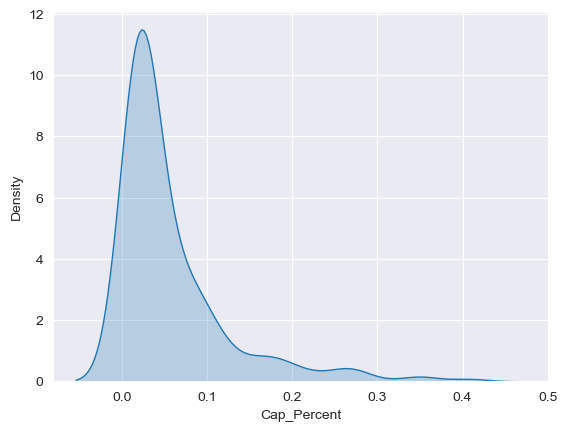

In [249]:
sns.kdeplot(data=y_train, fill='true')
# salary is right-skewed

In [250]:
#Given how many data points are collected on each player, I used a Pearson R correlation to determine which data points are most correlated to salary
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(X_train[x],y_train)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.767
Pearsons correlation for TRB: 0.431
Pearsons correlation for AST: 0.560
Pearsons correlation for FGA: 0.707
Pearsons correlation for FG: 0.753
Pearsons correlation for FG.: 0.074
Pearsons correlation for X3P: 0.417
Pearsons correlation for X3PA: 0.415
Pearsons correlation for X2P.: 0.015
Pearsons correlation for STL: 0.420
Pearsons correlation for BLK: 0.208
Pearsons correlation for ORB: 0.175
Pearsons correlation for DRB: 0.515
Pearsons correlation for FT: 0.700
Pearsons correlation for FTA: 0.669
Pearsons correlation for G: 0.346
Pearsons correlation for GS: 0.632
Pearsons correlation for MP: 0.664


In [251]:
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(X_train[x],y_train)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.752
Pearsons correlation for OWS: 0.705
Pearsons correlation for DWS: 0.544
Pearsons correlation for WS: 0.704
Pearsons correlation for WS.48: 0.283
Pearsons correlation for OBPM: 0.425
Pearsons correlation for DBPM: 0.009
Pearsons correlation for BPM: 0.357
Pearsons correlation for PER: 0.349
Pearsons correlation for TS.: 0.163
Pearsons correlation for eFG.: 0.087


**It seems that PTS (and things that lead to points like FG and FT) and VORP are the most strongly correlated to a player's salary**

[Text(0.5, 1.0, 'PTS v Avg Salary'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Contract Percent of Salary Cap')]

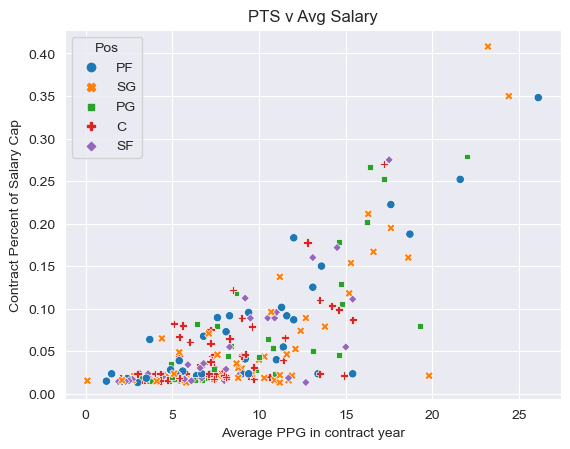

In [252]:
# PTS and salary has a very strong linear correlation
ax = sns.scatterplot(x='PTS',y=y_train, style = 'Pos', hue = "Pos", data = X_train)
ax.set(title="PTS v Avg Salary", xlabel="Average PPG in contract year", ylabel="Contract Percent of Salary Cap")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

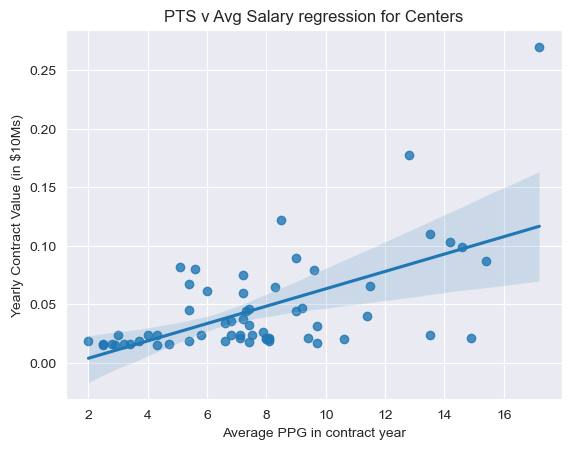

In [253]:
#It appears centers don't follow the linear pattern as closely as other positions
ax = sns.regplot(x='PTS', y= 'Cap_Percent', data = X_train.loc[X_train.Pos == 'C'])
ax.set(title="PTS v Avg Salary regression for Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for non-Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

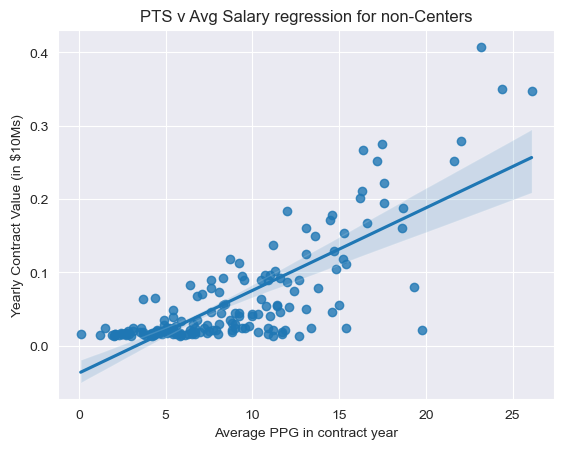

In [254]:
ax = sns.regplot(x='PTS',y='Cap_Percent', data = X_train.loc[X_train.Pos != 'C'])
ax.set(title="PTS v Avg Salary regression for non-Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

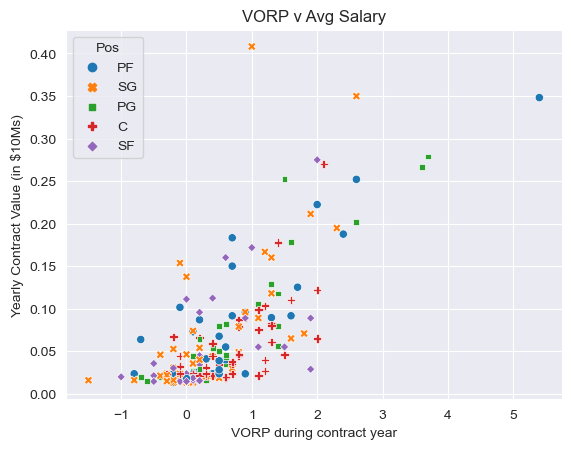

In [255]:
ax = sns.scatterplot(x='VORP',y='Cap_Percent', style = 'Pos', hue = "Pos", data = X_train)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

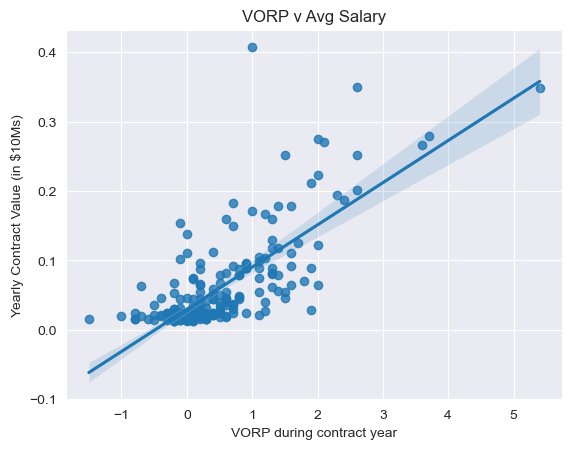

In [256]:
# VORP and salary has a strong linear correlation
ax = sns.regplot(x='VORP',y=y_train, data = X_train)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

Text(0.5, 1.0, 'Average Salary by position')

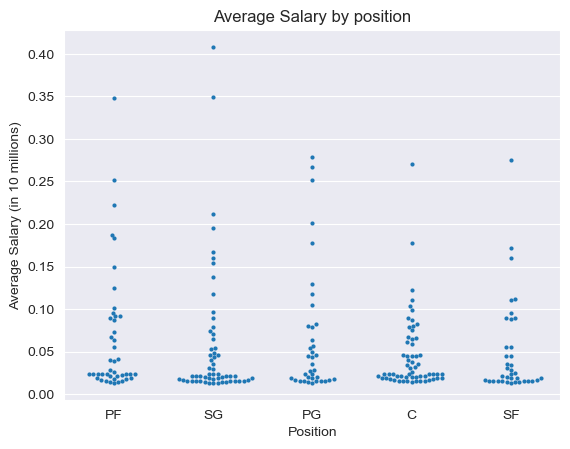

In [257]:
sns.swarmplot(x = 'Pos', y = y_train, s = 3, data = X_train)
plt.xlabel("Position")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Average Salary by position')
# In recent years the highest paid players have been SGs and SFs, but overall no position is being paid significantly more

#### Since certain positions are generally paid to do specific things in basketball (as we've seen PTS isn't as strong of an indicator for centers), I tried splitting the df into wings/guards and bigs

In [258]:
wings_df = X_train[(X_train.Pos == "SF") | (X_train.Pos == "SG") | (X_train.Pos == "PG")]
wings_test = X_test[(X_test.Pos == "SF") | (X_test.Pos == "SG") | (X_test.Pos == "PG")]
print(len(wings_df), len(wings_test))

131 45


In [259]:
#Rechecking correlation values for the split dfs
y = wings_df['Cap_Percent']
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.773
Pearsons correlation for TRB: 0.573
Pearsons correlation for AST: 0.632
Pearsons correlation for FGA: 0.732
Pearsons correlation for FG: 0.769
Pearsons correlation for FG.: 0.170
Pearsons correlation for X3P: 0.526
Pearsons correlation for X3PA: 0.536
Pearsons correlation for X2P.: 0.038
Pearsons correlation for STL: 0.420
Pearsons correlation for BLK: 0.212
Pearsons correlation for ORB: 0.218
Pearsons correlation for DRB: 0.604
Pearsons correlation for FT: 0.686
Pearsons correlation for FTA: 0.664
Pearsons correlation for G: 0.300
Pearsons correlation for GS: 0.644
Pearsons correlation for MP: 0.665


In [260]:
y = wings_df['Cap_Percent']
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.736
Pearsons correlation for OWS: 0.685
Pearsons correlation for DWS: 0.530
Pearsons correlation for WS: 0.695
Pearsons correlation for WS.48: 0.353
Pearsons correlation for OBPM: 0.536
Pearsons correlation for DBPM: 0.025
Pearsons correlation for BPM: 0.483
Pearsons correlation for PER: 0.531
Pearsons correlation for TS.: 0.195
Pearsons correlation for eFG.: 0.119


In [261]:
bigs_df = X_train[(X_train.Pos == "C")  | (X_train.Pos == "PF")]
bigs_test = X_test[(X_test.Pos == "C")  | (X_test.Pos == "PF")]

print(len(bigs_df), len(bigs_test))

103 34


In [262]:
y = bigs_df['Cap_Percent']
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.759
Pearsons correlation for TRB: 0.511
Pearsons correlation for AST: 0.515
Pearsons correlation for FGA: 0.678
Pearsons correlation for FG: 0.733
Pearsons correlation for FG.: 0.053
Pearsons correlation for X3P: 0.291
Pearsons correlation for X3PA: 0.280
Pearsons correlation for X2P.: 0.017
Pearsons correlation for STL: 0.441
Pearsons correlation for BLK: 0.361
Pearsons correlation for ORB: 0.321
Pearsons correlation for DRB: 0.561
Pearsons correlation for FT: 0.734
Pearsons correlation for FTA: 0.705
Pearsons correlation for G: 0.423
Pearsons correlation for GS: 0.628
Pearsons correlation for MP: 0.673


In [263]:
y = bigs_df['Cap_Percent']
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.803
Pearsons correlation for OWS: 0.793
Pearsons correlation for DWS: 0.614
Pearsons correlation for WS: 0.787
Pearsons correlation for WS.48: 0.290
Pearsons correlation for OBPM: 0.329
Pearsons correlation for DBPM: 0.005
Pearsons correlation for BPM: 0.269
Pearsons correlation for PER: 0.272
Pearsons correlation for TS.: 0.160
Pearsons correlation for eFG.: 0.076


## LINEAR REGRESSION MODELS ##

### ENTIRE DF ###

In [264]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = X_train[inputs]
# set y to avg_salary
y = y_train
# model
model = LinearRegression()
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(X_test[inputs])
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.03581752648479964


### Guards/Wings DF ###

In [265]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'VORP', 'AST', 'MP']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df['Cap_Percent']
#model
model = LinearRegression()
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.031752474439340914


### Bigs DF ###

In [266]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df['Cap_Percent']

model = LinearRegression()
model.fit(X,y)

# Predict RMSE
y_predicted = model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.03759029874328246


Overall, the linear regressions on the wings dataframes performed better than the linear regression on the overall dataframe while the bigs df performed similarly to the overall df. 

## DECISION TREE MODEL ##

In [267]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = X_train[inputs]
y = y_train

In [268]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X, y)
    
    y_predicted = model.predict(X_test[inputs])
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)

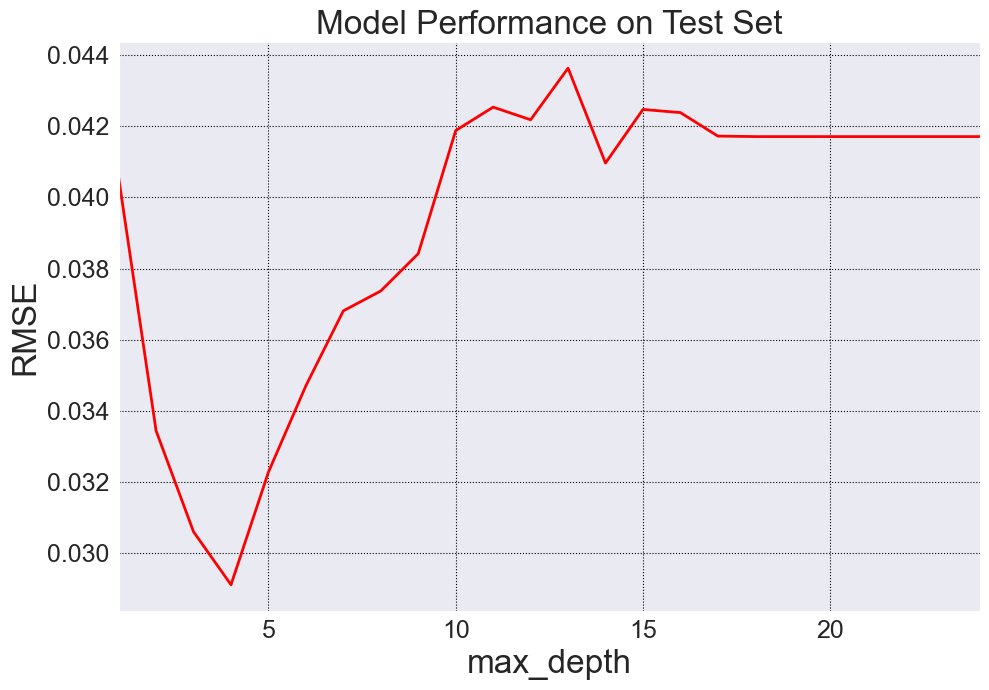

In [269]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [270]:
depth = 4
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(X_test[inputs])
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.029114290953669453


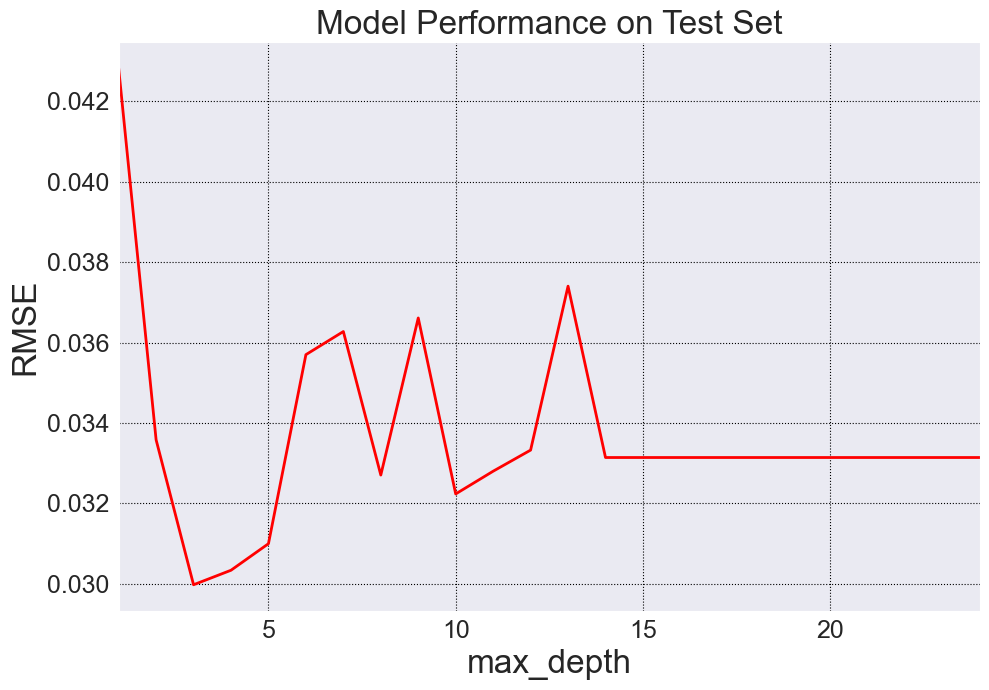

In [271]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'MP', 'AST']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df['Cap_Percent']

max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X, y)
    
    y_predicted = model.predict(wings_test[inputs])
    rmse = mean_squared_error(wings_test['Cap_Percent'], y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [272]:
depth = 3
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.029980425625392996


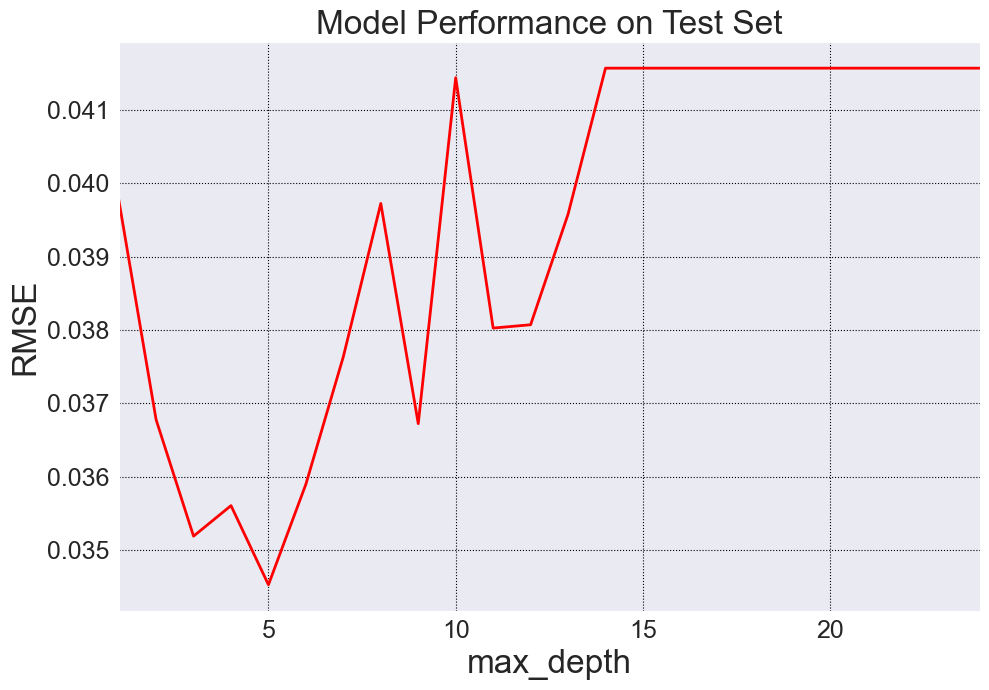

In [273]:
# use selected stats as predictor variable 
inputs = ['PTS', 'TRB', 'AST', 'Age']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df['Cap_Percent']

max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X, y)
    
    y_predicted = model.predict(bigs_test[inputs])
    rmse = mean_squared_error(bigs_test['Cap_Percent'], y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [274]:
depth = 5
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.03452856713544912


The decision tree outperformed the linear regression on all 3 dfs, the positional dfs also outperformed the overall df

## XGBOOST MODEL ##

In [275]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = X_train[inputs]
# set y to avg_salary
y = y_train

model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X,y)
# Predict RMSE
y_predicted = model.predict(X_test[inputs])
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.035718247607733816


In [285]:
# use selected stats as predictor variable 
inputs = ['PTS','Age','AST','DBPM', 'DRB']
X_train = wings_df[inputs]
# set y to avg_salary
y_train = wings_df['Cap_Percent']


wings_model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
wings_model.fit(X_train,y_train)
# Predict RMSE
y_predicted = wings_model.predict(wings_test[inputs])
rmse = mean_squared_error(wings_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.029481900345689625


In [283]:
# use selected stats as predictor variable 
inputs = ['PTS']
X_train = bigs_df[inputs]
# set y to avg_salary
y_train = bigs_df['Cap_Percent']

bigs_model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
bigs_model.fit(X_train,y_train)
# Predict RMSE
y_predicted = bigs_model.predict(bigs_test[inputs])
rmse = mean_squared_error(bigs_test['Cap_Percent'], y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.0384993680818298


Overall, the decision tree models generally performed the best and the bigs and wings models consistently outperformed the total models by a decent amount.